**Previous**: [The Problem](GOL_Intro.ipynb) 

# Deep Learning with Game Of Life, Part II
# Single Node Logistic Regression

In the second part of this notebook series I apply simple logistic regression model on the Game of Life pattern to see if it is possible to teach a single neuron to predict the cell iteration result from a Moore neighborhood.

My hypothesis on the result was expecting something above a coin toss accuracy, due to the small number of training examples and the learning capacity of a single node. Also, as there are four rules that dictate the iteration result, my assumption was that binary truth value set would not produce optimum fit. 


### Scenario

The data set is set up by creating the 512 Moore neighborhood permutations of 3x3 grids, and then shuffling the matrix on the first axis to get the train set randomized, although in this small amount of data it will not have a massive impact. In this experiment I simply split all the four decision sets in half by taking every second permutation to the training set, and every other to the test set. At the end of this file some notes on alternate splits and what sort of impact they had.

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

%matplotlib inline

# Import local utility functions
from utils import gol_utils as gol

## Create all possible permutations of 3x3 array
permutations = np.asarray([gol.bitfield(x) for x in range(0, (2**9))])

# Use a fixed seed for random ops to get uniform results in runs
np.random.seed(1)

## Prepare the sets for all combinations of pre/post iteration statuses, with a shuffled set
shuffled = permutations.copy()
np.random.shuffle(shuffled)
centers = np.asarray([(p[1][1]) for p in shuffled])
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in shuffled])

lived = shuffled[(1 == centers) & (1 == truths)]
spawned = shuffled[(0 == centers) & (1 == truths)]
died = shuffled[(1 == centers) & (0 == truths)]
empty = shuffled[(0 == centers) & (0 == truths)]


### Building the train and test sets

The following python block builds the train and test sets. For experimenting with different splits the ```bias_xxxx``` variables determine which percentage of the available permutations are taken into the train set. The truth value sets are created based on the same split for each rule. I'm using 50/50 split here between train and test sets, in Summary chapter below I elaborate a bit on how different splits changed the scene.

In [2]:
#Try with half the data for training, other half for testing (every second sample in each category)

bias_spawned = int(spawned.shape[0] / 100 * 50)
bias_died = int(died.shape[0] / 100 * 50)
bias_lived = int(lived.shape[0] / 100 * 50 )
bias_empty = int(empty.shape[0] / 100 * 50 )

train_set_x = spawned[:bias_spawned:]
train_set_x = np.concatenate((train_set_x, died[:bias_died:]), axis=0)
train_set_x = np.concatenate((train_set_x, lived[:bias_lived:]), axis=0)
train_set_x = np.concatenate((train_set_x, empty[:bias_empty:]), axis=0)

test_set_x = spawned[bias_spawned::]
test_set_x = np.concatenate((test_set_x, died[bias_died::]), axis=0)
test_set_x = np.concatenate((test_set_x, lived[bias_lived::]), axis=0)
test_set_x = np.concatenate((test_set_x, empty[bias_empty::]), axis=0)

train_set_y = np.ones([1, spawned[:bias_spawned:].shape[0]])
train_set_y = np.concatenate((train_set_y, np.zeros([1, died[:bias_died:].shape[0]])), axis=1)
train_set_y = np.concatenate((train_set_y, np.ones([1, lived[:bias_lived:].shape[0]])), axis=1)
train_set_y = np.concatenate((train_set_y, np.zeros([1, empty[:bias_empty:].shape[0]])),axis=1)

test_set_y = np.ones([1, spawned[bias_spawned::].shape[0]])
test_set_y = np.concatenate((test_set_y, np.zeros([1,died[bias_died::].shape[0]])), axis=1)
test_set_y = np.concatenate((test_set_y, np.ones([1, lived[bias_lived::].shape[0]])), axis=1)
test_set_y = np.concatenate((test_set_y, np.zeros([1, empty[bias_empty::].shape[0]])),axis=1)

# Flatten the train and test sets along the first axis (ending up with (9,m) sized arrays)
train_set_x_flat = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flat = test_set_x.reshape(test_set_x.shape[0], -1).T


### Learning Model

In Logistic Regression learning, a sigmoid function is used to calculate activation.

sigmoid(x) = 1 / (1 + *e*<sup>-x</sup>)

Sigmoid function is generally suited for calculating the output layer activation in binary classification scenarios.

The following functions block implements sigmoid and a number of utilities for preparing our logistic regression model.

In [9]:
# Sigmoid function for logistic regression
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def initialize_params(layer_dims):
    params = {}
    for l in range(1, len(layer_dims)):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return params


def compute_cost(AL, Y):
    cost = (-1 / Y.shape[1]) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

def propagate(w, b, X, Y):
    m = X.shape[1]
    
    A, cache = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = compute_cost(A, Y) #compute cost

    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs every 1000 training examples
        if i % 1000 == 0:
            costs.append(cost)
        
        # Print the cost every 10000 training examples
        if print_cost and i % 10000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# Prediction routine for computing probability after optimizing w and b
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A, _ = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        #turn the probability into binary output
        Y_prediction[A > 0.5] = 1
        Y_prediction[A <= 0.5] = 0
    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    initial_parameters = initialize_params([1, X_train.shape[0]])
   
    ww = initial_parameters['W1']
    bb = initial_parameters['b1']
    
    parameters, grads, costs = optimize(ww, bb[0], X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### Executing model on the data

Now to the actual business: Passing the train + test sets, iteration count and learning rate to the model for optimizing the parameters using gradient descent. Because of the small dataset, it is possible to use a relatively high number of iterations (100k) and still get the results in appropriate time.

The cost graph shows that the learning is not too effective, as the cost stays over 0.4 even after a significant number of iterations.

Resulting accuracy shows around 77% for training set and 76% for test set which in general means a slight overfit to the train set, but with a single node scenario it is not very indicative.

All in all, the result shows that logistic regression algorithm can predict the Game of life iteration result with accuracy around 75%, which is much better than just guessing (or tossing a coin). The error rate however is far away from estimated bayes error, which in the case of analysing GoL permutations could be pretty close to zero. A human can easily learn the rules and accurately "predict" the result of each permutation with 100% hit rate. That sets a bar that logistic regression alone can't get even close to.


Cost after iteration 0: 0.702226
Cost after iteration 10000: 0.498228
Cost after iteration 20000: 0.475155
Cost after iteration 30000: 0.461548
Cost after iteration 40000: 0.452554
Cost after iteration 50000: 0.446128
Cost after iteration 60000: 0.441300
Cost after iteration 70000: 0.437554
Cost after iteration 80000: 0.434587
Cost after iteration 90000: 0.432204
train accuracy: 72.265625 %
test accuracy: 71.875 %


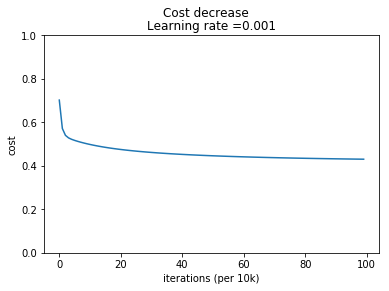

In [8]:
d = model(train_set_x_flat, train_set_y, test_set_x_flat, test_set_y, num_iterations = 100000, learning_rate = 0.001, print_cost = True)

# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.suptitle("Cost decrease")
plt.ylabel('cost')
plt.xlabel('iterations (per 10k)')
plt.title("Learning rate =" + str(d["learning_rate"]))
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

### Visualizing the logistic regression accuracy

To visualize how the single node scenario succeeds in predicting Game of life iteration result, in the next graph the decision spread is plotted per each permutation with the model prediction as an additional parameter. The permutations where the model learnt to predict the iteration result correctly are opaque, and those where the model failed to predict the result, are plotted with 0.3 alpha.

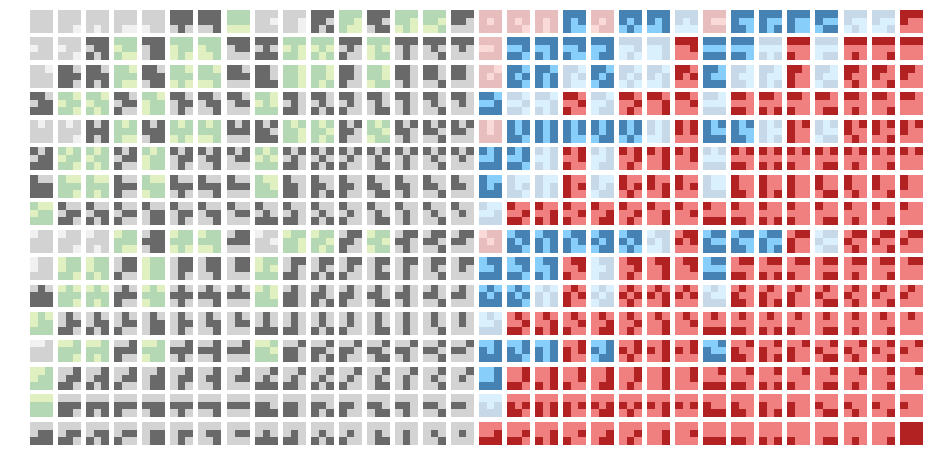

In [5]:
plt.figure(figsize=(16,8))
plt.title('Moore Neighborhood Permutations (Failed predictions with alpha 0.3)', fontsize=16)

colors = {"00":clrs.ListedColormap(['dimgray','lightgray']), #empty cells that stay dead
          "01":clrs.ListedColormap(['g','yellowgreen']),     #cells that spawn
          "11":clrs.ListedColormap(['steelblue','lightskyblue']), #alive cells that stay alive
          "10":clrs.ListedColormap(['firebrick', 'lightcoral'])} #alive cells that die

p_flat = permutations.reshape(permutations.shape[0],-1).T
w = d['w']
b = d['b']
predictions = predict(w,b,p_flat)

for index in range(0, permutations.shape[0]):
    old = permutations[index][1][1]
    new = gol.life_step_standard_rules(permutations[index])[1][1]
    predicted = predictions[0][index]
    colorkey = str(old)+str(new)
    key = colors[colorkey]
    a = 1.0
    if predicted != new:
        a = 0.3
    plt.subplot(16, 32, index+1)
    plt.axis("off")
    plt.imshow(permutations[index], cmap=key, alpha=a)

### Comparing prediction accuracy per rule

It is immediately visible from above diagram that the algorithm fails to predict any spawning cells correctly, and that the error rate in other categories varies. To gain a bit more insight on the result, the following block plots out the error rate graph per rule.

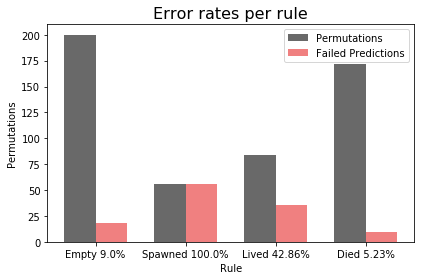

In [6]:
def barheights(dataset, expected):
    bar1 = len(np.squeeze(dataset))
    
    w = d['w']
    b = d['b']
    flatset = dataset.reshape(dataset.shape[0], -1).T
    preds = predict(w, b, flatset)
    errors = preds[preds != expected]
    
    return len(np.squeeze(dataset)), len(errors)

def error_rate(heights):
    return round(heights[1]/heights[0]*100,2)

bars_empty = barheights(empty, 0)
bars_spawned = barheights(spawned, 1)
bars_lived = barheights(lived, 1)
bars_died = barheights(died, 0)

bars = (bars_empty[0], bars_spawned[0], bars_lived[0], bars_died[0])
bar_errors = (bars_empty[1], bars_spawned[1], bars_lived[1], bars_died[1])

# Plot the decision accuracy
n_groups = 4
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.bar(index, bars, bar_width,
                 color='dimgray',
                 label='Permutations')

rects2 = plt.bar(index + bar_width, bar_errors, bar_width,
                 color='lightcoral',
                 label='Failed Predictions')

plt.xlabel('Rule')
plt.ylabel('Permutations')
plt.title('Error rates per rule', fontsize=16)
plt.xticks(index + bar_width / 2, ('Empty ' + str(error_rate(bars_empty)) + "%", 
                                   'Spawned ' + str(error_rate(bars_spawned)) + "%", 
                                   'Lived ' + str(error_rate(bars_lived)) + "%", 
                                   'Died ' + str(error_rate(bars_died)) + "%"))
plt.legend()

plt.tight_layout()
plt.show()


### How logistic regression views the permutations

For a clearer view on how the model interprets the problem, below code renders the same permutations graph with coloring based on the model's prediction. 

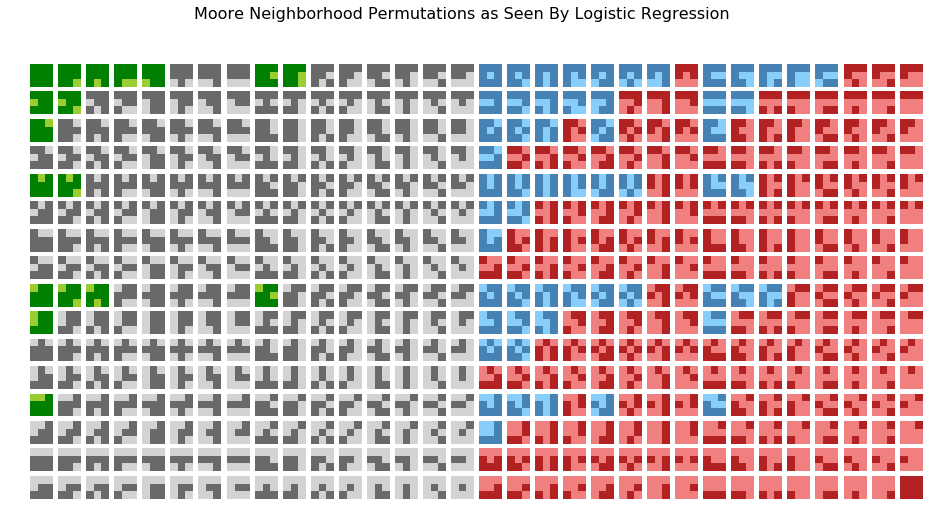

In [7]:
plt.figure(figsize=(16,8))
plt.suptitle('Moore Neighborhood Permutations as Seen By Logistic Regression', fontsize=16)

for index in range(0, permutations.shape[0]):
    old = permutations[index][1][1]
    predicted = predictions[0][index]
    colorkey = str(old)+str(int(predicted))
    key = colors[colorkey]
    plt.subplot(16, 32, index+1)
    plt.axis("off")
    plt.imshow(permutations[index], cmap=key)

### Animated side-by-side display

The following code renders a randomly generated 40x40 grid and animates that for 100 generations, left side is the model taught above, and right side is the real Game of Life algorithm. 

Based on my test runs it appears that the logistic regression model with grids that are 50% populated at start evolves some 20-35 generations, after which it ends up being just an oscillator or completely dead.

The original game of life patterns tend to have a lot longer lifespan, depending on the initial density. I found [Nathaniel Johnston's Blog](http://www.njohnston.ca/2009/07/the-maximal-lifespan-of-patterns-in-conways-game-of-life/) that touched this particular issue with some interesting analysis. 

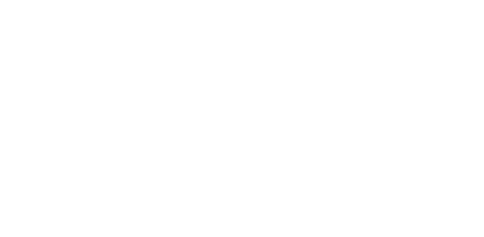

In [8]:
from IPython.display import HTML
from matplotlib import animation

# settings for the animation 
gridsize = 40
gens = 100
ival = 100

# Create a random game grid of 50% density 
GAME = np.random.randint(2, size=(gridsize,gridsize))
GAME_REF = GAME

def life_step_lr(GRID):
    #create rim around the game area for torus-like op 
    expGame = np.pad(GRID,[(1,1),(1,1)], mode='wrap')
    #roll the game grid into array of moore neighborhoods
    C = np.lib.stride_tricks.as_strided(expGame, shape=(gridsize, gridsize, 3, 3), strides=expGame.strides + expGame.strides)
    C2 = C.reshape((gridsize)*(gridsize),9).transpose(1,0)
    preds = predict(w,b,C2).reshape(gridsize, gridsize)
    return preds

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.axis("off")
ax2.axis("off")
fig.set_size_inches(8, 4)

ims = []

#render generations
for g in range(0,gens):
    GAME = life_step_lr(GAME)
    GAME_REF = gol.life_step_standard_rules(GAME_REF)
    im = ax1.imshow(GAME, animated=True)
    im2 = ax2.imshow(GAME_REF, animated=True)
    ims.append([im, im2])

anim = animation.ArtistAnimation(fig,ims,interval=ival)
HTML(anim.to_html5_video())

### Summary

As expected, the single node scenario did not yield very high learning result. What did surprise me though was that the algorithm was not able to predict any of the spawning permutations correctly, while getting much lower error rates on other sets. In retrospect, it started to make sense considering the number of all permutations that result in living cell being less than one third of the full dataset. 

When experimenting with learning rate, number of iterations while optimizing and size of the training set I noticed only minor effects on the test accuracy, which fluctuated between 73% and 77%.

By increasing the number of training examples from the spawning and living sets, the algorithm learns to predict living permutations better, but for spawning cells the error rate stays at 100% or very close to it. Even in a setup where ALL the spawning permutations are included in training, the model only predicts correctly 2 out of 56 for spawning cells. 

The actual Game of life ruleset gives a 27% living scenarios ratio, and this algorithm ends up around 15% => rather pessimistic view of life 😬

Next part in this series is about applying a multi-layer neural network on the dataset. My hypothesis is that multilayered NN will give immediately better results, and I also expect that by tuning the learning parameters it is possible to further enhance the prediction accuracy. 

**Next**: [Multi-Layer Neural Net](GOL_NN.ipynb)